In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
# Define paths
cwd_path = Path.cwd().resolve()

obs_path = cwd_path.parents[0] / 'Data' / 'Drone_observation'
prior_path = cwd_path.parents[0] / 'Data' / 'Processed_files' / 'Processed_files_flight_21'
posterior_path = cwd_path.parents[0] / 'Data' / 'Processed_files' / 'Processed_files_flight_21_calibrated'

In [3]:
# Initialize result DataFrames, one per drone
drone_col_names = ["drone21", "drone23", "drone25", "drone90"]

result_df_dict = {
    drone: pd.DataFrame(
        columns=[
            "time",
            "theta_obs",
            "theta_prior_ens_mean",
            "theta_prior_ens_std",
            "theta_posterior_ens_mean",
            "theta_posterior_ens_std",
        ]
    )
    for drone in drone_col_names
}

result_df_dict

{'drone21': Empty DataFrame
 Columns: [time, theta_obs, theta_prior_ens_mean, theta_prior_ens_std, theta_posterior_ens_mean, theta_posterior_ens_std]
 Index: [],
 'drone23': Empty DataFrame
 Columns: [time, theta_obs, theta_prior_ens_mean, theta_prior_ens_std, theta_posterior_ens_mean, theta_posterior_ens_std]
 Index: [],
 'drone25': Empty DataFrame
 Columns: [time, theta_obs, theta_prior_ens_mean, theta_prior_ens_std, theta_posterior_ens_mean, theta_posterior_ens_std]
 Index: [],
 'drone90': Empty DataFrame
 Columns: [time, theta_obs, theta_prior_ens_mean, theta_prior_ens_std, theta_posterior_ens_mean, theta_posterior_ens_std]
 Index: []}

In [4]:
# Read data
obs_df = pd.read_csv(obs_path / 'flight_21_1_Processed.csv')

# Prior ensemble members
prior_df_list = []
posterior_df_list = []

# Loop through ensemble members, we have 64
for idx in [i+1 for i in range(64)]:

    prior_df_list.append(
        pd.read_csv(prior_path / f'zac_shf_{idx}_output.csv')
    )
    
    posterior_df_list.append(
        pd.read_csv(posterior_path / f'zac_shf_calibrated_flight21_{idx}_output.csv')
    )

obs_df.head()

,time,step_counter,utm_x,utm_y,utm_z,theta,wind_speed,wind_direction,drone,seconds_after_takeoff,grid_x,grid_y,grid_z
0,2022-08-24 10:26:05,5,513279,8265342,18.092968,279.149469,0.000000,0.000000,drone90,5,55,129,4
1,2022-08-24 10:26:10,5,513278,8265333,36.359302,278.483022,0.087727,0.114062,drone90,10,55,129,5
2,2022-08-24 10:26:15,5,513273,8265258,58.068725,277.652978,1.833203,2.616081,drone90,15,55,124,7
3,2022-08-24 10:26:20,5,513351,8265248,91.516668,277.419260,1.910149,2.840212,drone90,20,60,123,9
4,2022-08-24 10:26:25,5,513396,8265327,116.744688,277.329725,2.064087,2.590659,drone90,25,63,128,10


In [5]:
prior_df_list[0].head()

,time,theta,u,v,timestep_counter,drone,grid_x,grid_y,grid_z,seconds_after_takeoff
0,01:00:05,275.24136,4.218990,-6.333270,4,drone90,55,129,4,5
1,01:00:10,275.28010,4.307123,-6.599183,4,drone90,55,129,5,10
2,01:00:15,275.28522,3.849536,-6.782267,4,drone90,55,124,7,15
3,01:00:20,275.25850,3.346809,-6.923422,4,drone90,60,123,9,20
4,01:00:25,275.22595,2.895743,-7.062019,4,drone90,63,128,10,25


In [6]:
posterior_df_list[0].head()

,time,theta,u,v,timestep_counter,drone,grid_x,grid_y,grid_z,seconds_after_takeoff,wind_speed,wind_dir
0,01:00:05,279.13898,-3.200851,-3.605639,5,drone90,52,125,4,5,4.821419,3.986392
1,01:00:10,279.15768,-3.333711,-3.544464,5,drone90,52,125,5,10,4.865887,3.957622
2,01:00:15,279.16690,-3.464646,-3.576629,5,drone90,52,120,7,15,4.979563,3.942893
3,01:00:20,279.15594,-3.570042,-3.528484,5,drone90,57,119,9,20,5.019501,3.921136
4,01:00:25,279.12622,-3.540297,-3.285022,5,drone90,60,124,10,25,4.829604,3.889607


In [7]:
# Extract data and calculate ensemble means

n_ensemble_members = 64
n_obs = prior_df_list[0].shape[0]

for drone in drone_col_names:

    # Observations

    result_df_dict[drone]["theta_obs"] = obs_df[obs_df["drone"] == drone]["theta"]

    # Prior ensemble stats

    prior_thetas = pd.DataFrame(columns=["theta"])

    for idx, df in enumerate(prior_df_list):
        # Extract time in first iter
        if idx == 0:
            result_df_dict[drone]["time"] = pd.to_datetime(
                df[df["drone"] == drone]["time"], format="%H:%M:%S"
            )
        # Subset current drone
        df_subset = df[df["drone"] == drone]
        # Store current thetas
        prior_thetas[f"ens_{idx}"] = df_subset["theta"]
    # Calculate and store mean and std
    result_df_dict[drone]["theta_prior_ens_mean"] = prior_thetas.mean(axis=1)
    result_df_dict[drone]["theta_prior_ens_std"] = prior_thetas.std(axis=1)

    # Posterior ensemble stats

    posterior_thetas = pd.DataFrame(columns=["theta"])

    for idx, df in enumerate(posterior_df_list):
        # Subset current drone
        df_subset = df[df["drone"] == drone]
        # Store current thetas
        posterior_thetas[f"ens_{idx}"] = df_subset["theta"]
    # Calculate and store mean and std
    result_df_dict[drone]["theta_posterior_ens_mean"] = posterior_thetas.mean(axis=1)
    result_df_dict[drone]["theta_posterior_ens_std"] = posterior_thetas.std(axis=1)

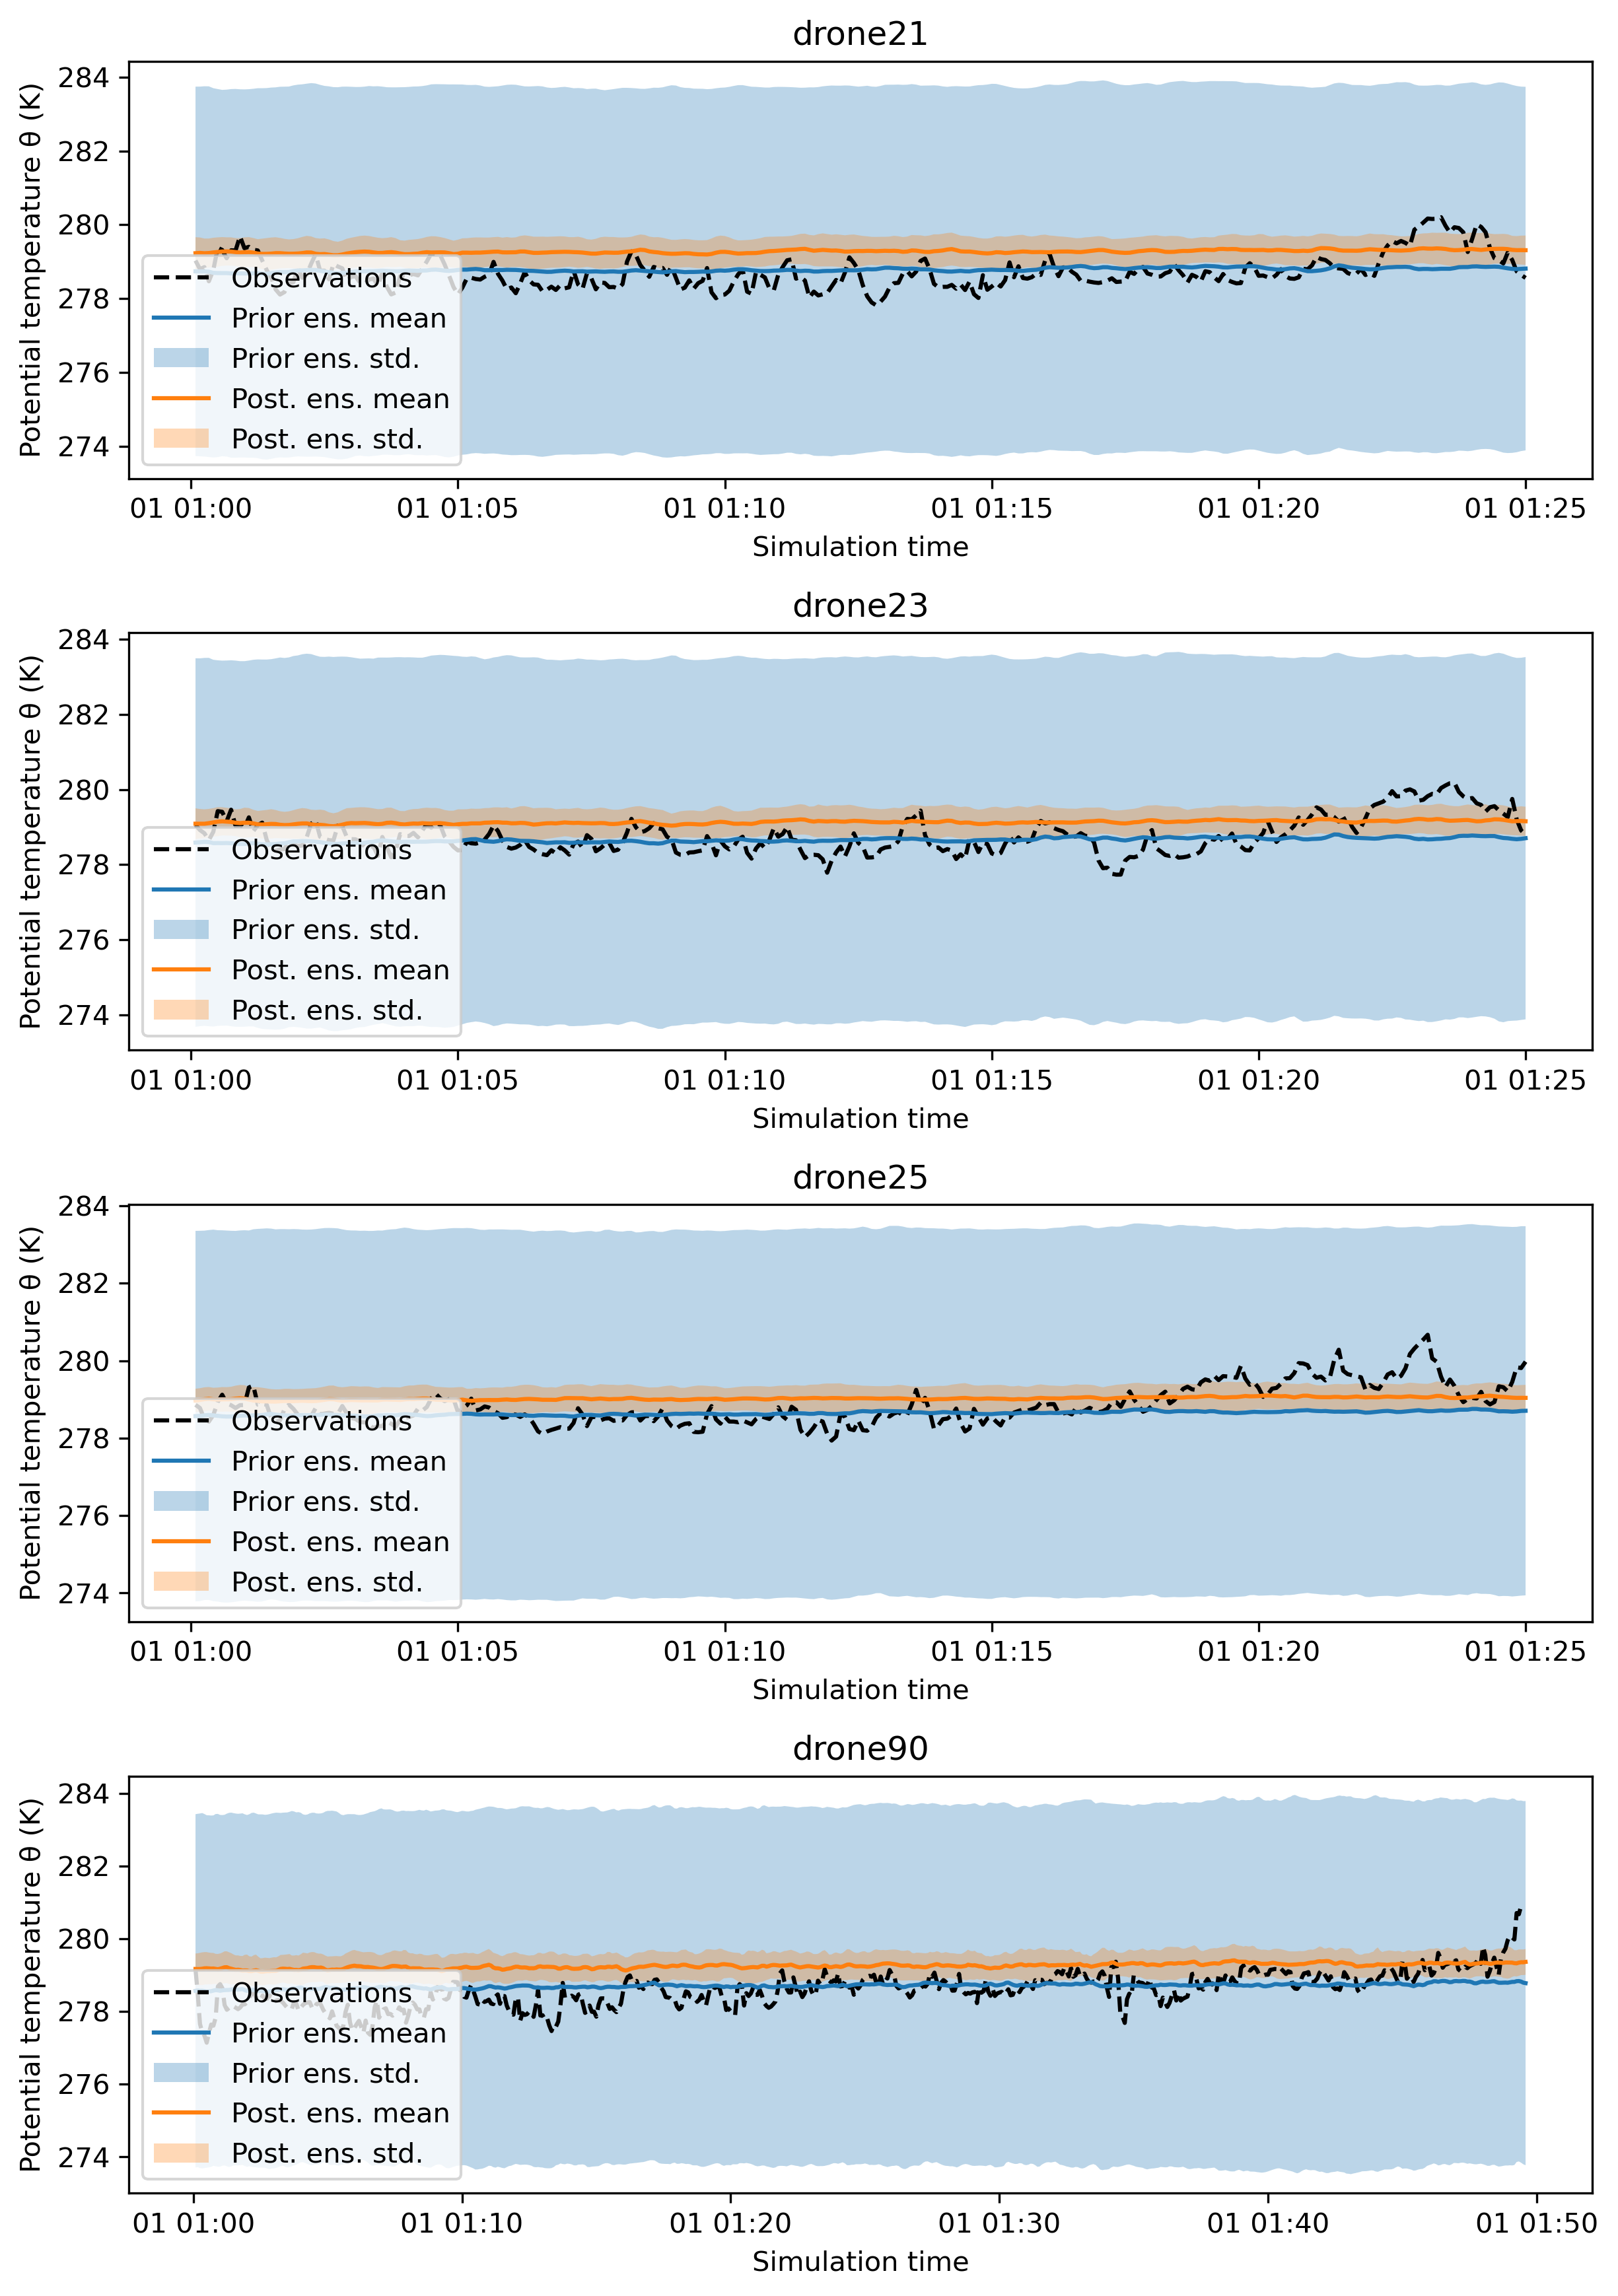

In [8]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(8.27, 11.69), dpi=300)

for idx, (drone_name, drone_df) in enumerate(result_df_dict.items()):

    # Plot observations
    
    axes[idx].plot(
        drone_df["time"],
        drone_df["theta_obs"],
        label="Observations",
        color="black",
        linestyle="dashed",
    )


    # Plot prior ensemble mean
    
    axes[idx].plot(
        drone_df["time"], drone_df["theta_prior_ens_mean"], label="Prior ens. mean"
    )
    # Plot prior ensemble std
    y = pd.to_numeric(drone_df["theta_prior_ens_mean"], errors="coerce")
    std = pd.to_numeric(drone_df["theta_prior_ens_std"], errors="coerce")
    axes[idx].fill_between(
        x=drone_df["time"],
        y1=y
        - std,  # (drone_df["theta_prior_ens_mean"] - drone_df["theta_prior_ens_std"]),
        y2=y
        + std,  # (drone_df["theta_prior_ens_mean"] + drone_df["theta_prior_ens_std"]),
        alpha=0.3,
        label="Prior ens. std.",
    )


    # Plot posterior ensemble mean
    
    axes[idx].plot(
        drone_df["time"], drone_df["theta_posterior_ens_mean"], label="Post. ens. mean"
    )
    # Plot prior ensemble std
    y = pd.to_numeric(drone_df["theta_posterior_ens_mean"], errors="coerce")
    std = pd.to_numeric(drone_df["theta_posterior_ens_std"], errors="coerce")
    axes[idx].fill_between(
        x=drone_df["time"],
        y1=y
        - std,  # (drone_df["theta_prior_ens_mean"] - drone_df["theta_prior_ens_std"]),
        y2=y
        + std,  # (drone_df["theta_prior_ens_mean"] + drone_df["theta_prior_ens_std"]),
        alpha=0.3,
        label="Post. ens. std.",
    )

    # Set title etc.
    axes[idx].set_title(f"{drone_name}")
    axes[idx].set_xlabel("Simulation time")
    axes[idx].set_ylabel("Potential temperature θ (K)")
    axes[idx].legend(loc="lower left")
    
    # Save
    fig.tight_layout()
    fig.savefig(cwd_path.parents[0] / 'Tables_and_Figures' / 'potential_temp_timeseries.png')